# Bayesian Optimization  _ M-MTC

In [2]:
from Utils import load_data, preprocessing, model_performances
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import json
import keras
from functools import partial
#from bayes_opt import BayesianOptimization
from sklearn.metrics import classification_report
import time

In [3]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt import plots
from skopt.utils import use_named_args
from collections import namedtuple

In [4]:
#disable warnings
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

## Utils

In [5]:
#identity_tag_path = './Data/Categories.txt'
label_column = "misogynous"
input_columns = ['text_USE', 'caption_USE']
threshold = 0.5

embed_size = 512  # 512-length array with Universal Sentence Encoder algorithm
input_shape = embed_size*2
batch_size = 64
epochs = 100

In [6]:
# ________________________________________Utils ___________________________________________________
MODELNAMES = ['multimodal_text_tags_BO_v{}'.format(i) for i in range(10)]
path_models = "./Mitigated/models/"
path_predictions= "./Mitigated/predictions/"
path_performances = "./Mitigated/performances"
model_name = 'multimodal_text_tags'

results_txt_path = path_performances + 'BO_results.txt'

for path in [path_models, path_predictions, path_performances]:
    if not os.path.exists(path):
        os.makedirs(path)

file = open(results_txt_path, 'a+')
file.truncate(0)  # erase file content
file.close()

## Load Data

In [7]:
# ________________________________________load training data ___________________________________________________
meme_df = load_data.load_azure_caption_training()

In [8]:
meme_df['text_USE'] = preprocessing.use_preprocessing(meme_df, 'Text Transcription')
meme_df['caption_USE'] = preprocessing.use_preprocessing(meme_df, 'caption')

In [9]:
# ________________________________________load test data ___________________________________________________
test_df = load_data.load_azure_caption_test()
test_df['text_USE'] = preprocessing.use_preprocessing(test_df, 'Text Transcription')
test_df['caption_USE'] = preprocessing.use_preprocessing(test_df, 'caption')

x_test, y_test = preprocessing.elaborate_input(test_df, input_columns, label_column)

In [10]:
# ________________________________________load synthetic data ___________________________________________________
syn_df = load_data.load_azure_caption_syn()
syn_df = load_data.shuffle_syn(syn_df, 'file_name')

syn_df['text_USE'] = preprocessing.use_preprocessing(syn_df, 'Text Transcription')
syn_df['caption_USE'] = preprocessing.use_preprocessing(syn_df, 'caption')

In [11]:
res_test = test_df[['file_name', 'misogynous']].copy()
res_syn = syn_df[['file_name', 'misogynous']].copy()

In [12]:
Identity_Terms = load_data.read_identity_terms()
Identity_Tags = load_data.read_identity_tags()

In [14]:
syn_df = syn_df.merge(load_data.load_syn_identity_data().drop(columns=['misogynous', 'Text Transcription']),
                      how='inner', on="file_name")

## Bayesian Optimization _ Utils

In [15]:
# define a search space as a List
search_space = list()
search_space.append(Real(0.00001, 0.1, 'log-uniform', name='lr'))
search_space.append(Real(1e-8, 1, 'log-uniform', name='epsilon'))
search_space.append(Integer(64, input_shape, name='neurons'))
search_space.append(Categorical(['sigmoid', 'relu', 'tanh', 'LeakyReLU'], name='activation_function'))
search_space.append(Real(0.1, 0.6, 'log-uniform', name='dropout'))

In [16]:
default_parameters={"lr":0.00001,
        "epsilon": 1e-7,
        "neurons": 512, 
        "activation_function": 'LeakyReLU',
        "dropout": 0.2
    }

In [17]:
# distinguish variable parameter from fixed parameters in 10Fold execution
VariableParams = namedtuple('VariableParams', 'lr epsilon neurons activation_function dropout')
FixedParams = namedtuple('FixedParams', 'iteration dataset syn_data train_index test_index')

In [18]:
def fitness(v_args, f_args):
    """  A function that will be called by the search procedure. 
    This is a function expected by the optimization procedure later and takes a model and set of specific
    hyperparameters for the model, evaluates it, and returns a score for the set of hyperparameters ( the value to maximize).

    This is the function that creates and trains a neural network with the given hyper-parameters, and then evaluates its
    performance on the validation-set. The function then returns the so-called fitness value (aka. objective value),
    which is the negative final_multimodal_Score on the validation-set. 
    It is negative because skopt performs minimization instead of maximization.

    It creates a model and train that with the parameters (lr and epsilon) passed
    as input. The trained model is used to make predictions on test and on syn
    and finally the predictions are used to compute the multimodal bias metric
    (value to maximize).
    """
    iteration = f_args.iteration
    syn_data = f_args.syn_data
	
    saving_folder = path_models + f'Iteration_{iteration}/'.format(iteration=iteration)
    if not os.path.exists(saving_folder):
        os.makedirs(saving_folder)

    # configure the data
    x_train, y_train, x_val, y_val, x_test, y_test = preprocessing.elaborate_data_10fold(f_args.dataset, f_args.train_index,
                                                                                            f_args.test_index, iteration,
                                                                                            input_columns, label_column)


    # configure the model with specific hyperparameters
    model, _ = model_performances.get_trained_model(x_train, 
                            y_train, 
                            x_val, 
                            y_val,
                            input_shape=input_shape, 
                            activation_function=v_args.activation_function, 
                            neurons=v_args.neurons, 
                            dropout=v_args.dropout, 
                            lr=v_args.lr, 
                            epsilon=v_args.epsilon, 
                            epochs=epochs,
                            batch_size=batch_size)


    # save the model
    model.save(path_models + 'BO_model_multimodal_text_tags_' + str(iteration))

    # make prediction on the test fold of Training data
    predict_values = model.predict(x_test, batch_size=batch_size)
    test_data = f_args.dataset.iloc[f_args.test_index, :].copy()
    test_data['pred_perc'] = predict_values

    csv_name = saving_folder + model_name + '_' + 'Train' + '_' + str(iteration) + '_' + str(int(time.time())) + '.csv'
    test_data.to_csv(csv_name, index=False, sep='\t')

    # make prediction on syn
    x_syn_BO, y_syn_BO = preprocessing.elaborate_input(syn_data, input_columns, label_column)

    predict_values = model.predict(x_syn_BO, batch_size=batch_size)
    syn_data['pred_perc'] = predict_values

    csv_name = saving_folder + 'multimodal_text_tags_BO' + '_' + 'SYN' + '_' + str(iteration) + '_' + str(int(time.time())) + '.csv'
    syn_data.to_csv(csv_name, index=False, sep='\t')

    # BIAS:
    identity_terms_present = model_performances.identity_element_presence(syn_data, Identity_Terms, label_column)
    tags_present = model_performances.identity_element_presence_OR(syn_data, Identity_Tags, label_column)


    bias_metrics_text = model_performances.compute_bias_metrics_for_model(syn_data, identity_terms_present, 'pred_perc',
                                                                            label_column)

    bias_metrics_image = model_performances.compute_bias_metrics_for_model(syn_data, tags_present, 'pred_perc',
                                                                            label_column)

    overall_auc_metrics = model_performances.calculate_overall_auc(test_data, 'pred_perc')

    final_multimodal_scores = model_performances.get_final_multimodal_metric_nan(bias_metrics_text, bias_metrics_image,
                                                                                overall_auc_metrics, 'pred_perc')

    model_performances.write_performance_on_file(saving_folder + 'results_{it}.txt'.format(it=iteration), iteration,
                                                    bias_metrics_text, bias_metrics_image, overall_auc_metrics,
                                                    final_multimodal_scores)

    # Because we are interested in the HIGHEST classification
    # metric, we need to negate this number so it can be minimized
    return -final_multimodal_scores  # Metric to maximize

In [19]:
# new objective passed to the optimizer
# sub-version of the black_box_function (fitness) with blocked value that need to stay stable during optimization (e.g. iteration)
@use_named_args(dimensions=search_space)
def objective(lr, epsilon, neurons, activation_function, dropout):
    variable_args = VariableParams(lr, epsilon, neurons, activation_function, dropout)
    return fitness(variable_args, fixed_args) #fixed_args as global variable

## Bayesian Optimization

In [ ]:
iteration = 0
kf = KFold(n_splits=10, shuffle=False)
syn_folds = kf.split(syn_df)
syn_pred = []
syn_10_df=pd.DataFrame()

for train_index, val_index in kf.split(meme_df):
    preprocessing.set_seed(iteration)
    print('___ITERATION {it}___'.format(it=iteration))
    MODELNAME = MODELNAMES[iteration]
    # clear session
    tf.keras.backend.clear_session()

    BO_test_syn, test_syn = next(syn_folds)
    BO_syn_data = syn_df.iloc[BO_test_syn, :]
    syn_data = syn_df.iloc[test_syn, :]
    x_syn, y_syn = preprocessing.elaborate_input(syn_df.iloc[test_syn, :], input_columns, label_column)

    fixed_args = FixedParams(iteration=iteration, dataset=meme_df, syn_data=BO_syn_data, train_index=train_index, test_index=val_index)
    search_result = gp_minimize(func=objective,
                                dimensions=search_space,
                                acq_func='EI', # Expected Improvement.
                                n_calls=40,
                                x0=list(default_parameters.values()),
                                n_random_starts=5)
                        
    # TRAIN OF A NEW MODEL ON TRAINING DATA (9fold train-1fold val) TO COMPUTE FINAL METRICS
    x_train, y_train = preprocessing.elaborate_input(meme_df.iloc[train_index, :], input_columns, label_column)
    x_val, y_val = preprocessing.elaborate_input(meme_df.iloc[val_index, :], input_columns, label_column)

    optimal_config = dict(zip(list(default_parameters.keys()), search_result.x)) #uses the same keys in default_parameters

    model, _ = model_performances.get_trained_model(x_train, 
                                y_train, 
                                x_val, 
                                y_val,
                                input_shape=input_shape, 
                                activation_function=optimal_config['activation_function'], 
                                neurons=optimal_config['neurons'], 
                                dropout=optimal_config['dropout'], 
                                lr=optimal_config['lr'], 
                                epsilon=optimal_config['epsilon'], 
                                epochs=epochs,
                                batch_size=batch_size)

    # make prediction on test
    predict_values_test = model.predict(x_test, batch_size=batch_size)

    res_test[MODELNAME] = pd.DataFrame(predict_values_test)[0]
    res_test[['file_name', 'misogynous', MODELNAME]].to_csv(
        path_predictions + 'BO_Final_Test_' + str(iteration) + '_' + str(int(time.time())) + '.csv', index=False, sep='\t')

    # make prediction on syn
    predict_values_test = model.predict(x_syn, batch_size=batch_size)

    """ dataframe: for each model, three columns are added:
    - 'label_'+MODELNAME: real values
    - MODELNAME: predictions
    -'file_name_'+MODELNAME: ids of the memes

    """
    syn_10_df['label_'+MODELNAME]=list(syn_df[label_column][test_syn].values)
    syn_10_df[MODELNAME]= predict_values_test
    syn_10_df['file_name_'+MODELNAME]=list(syn_df['file_name'][test_syn].values)

    syn_data[MODELNAME] = predict_values_test #pd.DataFrame(predict_values_test)[0]
    syn_data[['file_name', 'misogynous', MODELNAME]].to_csv(
        path_predictions + 'BO_Final_Syn_' + str(iteration) + '_' + str(int(time.time())) + '.csv', index=False, sep='\t')

    identity_terms_present = model_performances.identity_element_presence(syn_data, Identity_Terms,label_column)
    tags_present = model_performances.identity_element_presence_OR(syn_data, Identity_Tags, label_column)
    # BIAS:
    bias_metrics_text = model_performances.compute_bias_metrics_for_model(syn_data, identity_terms_present, MODELNAME,
                                                                        label_column)
    bias_metrics_image = model_performances.compute_bias_metrics_for_model(syn_data, tags_present, MODELNAME,
                                                                        label_column)
    overall_auc_metrics = model_performances.calculate_overall_auc(res_test, MODELNAME)

    final_multimodal_scores = model_performances.get_final_multimodal_metric_nan(bias_metrics_text, bias_metrics_image,
                                                                            overall_auc_metrics, MODELNAME)

    model_performances.write_performance_on_file(results_txt_path, iteration, bias_metrics_text, bias_metrics_image,
                                                overall_auc_metrics, final_multimodal_scores)
    iteration = iteration + 1


In [21]:
# Performance Syn 10Fold split
model_performances.multimodal_bias_metrics_on_file_10Fold(results_txt_path, res_test, syn_10_df, Identity_Terms, Identity_Tags,
                                                   MODELNAMES, label_column)

<AxesSubplot: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

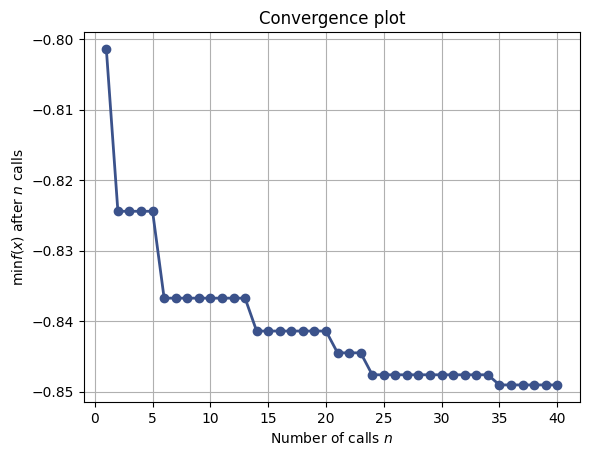

In [22]:
plots.plot_convergence(search_result)

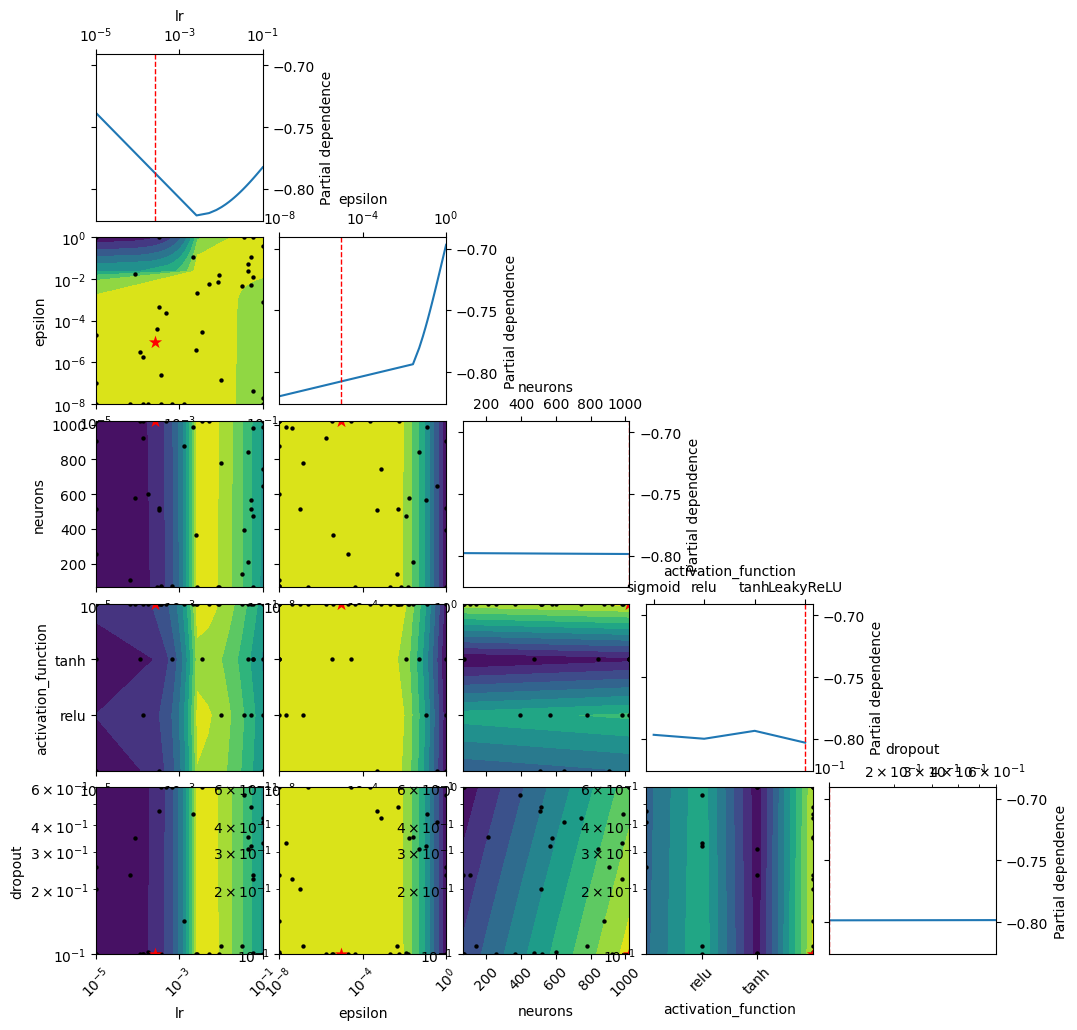

In [23]:
fig=plots.plot_objective(result=search_result)

In [24]:
syn_10_df.to_csv(path_predictions + 'MTC_syn_10_df.csv', index=False, sep='\t')